# SERP Heatmap

> Using multiple SERP datasets, create a heatmap for each domain, showing how often it appeared on each position of the SERPs, with some summary statistics.

In [ ]:
# | default_exp serp_heatmap

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | echo: false
# from IPython.display import HTML
# import json

# jsonld_dict = {
#   "@context": "https://schema.org",
#   "@type": "HowTo",
#   "name": "Analyze SERPs on a large scale",
# }
# js = f'<script type="application/ld+json">{json.dumps(jsonld_dict)}</script>'
# print(js)

In [ ]:
# | export
import plotly.graph_objects as go
import pandas as pd

pd.options.display.max_columns = None

In [ ]:
# | export
def _concat(text):
    return "<br>".join(sorted(text))

In [ ]:
# | export
def serp_heatmap(
    serp_df, num_domains=10, height=650, width=None, title="SERP Heatmap", theme="none"
):
    """Create a heatmap for visualizing domain positions on SERPs.

    Parameters
    ----------

    serp_df : pandas.DataFrame
      A DataFrame retreived from running advertools.serp_goog or advertools.serp_youtube. Any similar SERP
      DataFrame would do, with the simple requirement of containing three columns: searchTerms, displayLink, and rank.
    num_domains : int
      The number of domains to display in the chart, default 10.
    height : int
      The height in pixels of the chart.
    width : int
      The width in pixels of the chart.
    title : str
      The title of the chart.
    theme : str
      The theme to apply to the chart.

    Returns
    -------
    heatmap_fig : plotly.graph_objects.Figure
    """
    df = serp_df[["searchTerms", "rank", "displayLink"]]
    top_domains = df["displayLink"].value_counts()[:num_domains].index.tolist()
    top_df = df[df["displayLink"].isin(top_domains) & df["displayLink"].ne("")]
    top_df_counts_means = top_df.groupby("displayLink", as_index=False).agg(
        {"rank": ["count", "mean"]}
    )
    top_df_counts_means.columns = ["displayLink", "rank_count", "avg_pos"]
    top_df = pd.merge(top_df, top_df_counts_means).sort_values(
        ["rank_count", "avg_pos"], ascending=[False, True]
    )
    hovertxt_df = top_df.groupby(["rank", "displayLink"], as_index=False).agg(
        {"searchTerms": _concat}
    )
    rank_counts = (
        top_df.groupby(["displayLink", "rank"]).agg({"rank": ["count"]}).reset_index()
    )
    rank_counts.columns = ["displayLink", "rank", "count"]
    summary = (
        df.groupby(["displayLink"], as_index=False)
        .agg({"rank": ["count", "mean"]})
        .sort_values(("rank", "count"), ascending=False)
        .assign(
            coverage=lambda df: (df[("rank", "count")].div(df[("rank", "count")].sum()))
        )
    )
    summary.columns = ["displayLink", "count", "avg_pos", "coverage"]
    summary["displayLink"] = summary["displayLink"].str.replace("www.", "", regex=True)
    summary["avg_pos"] = summary["avg_pos"].round(1)
    summary["coverage"] = summary["coverage"].mul(100).round(1).astype(str).add("%")
    num_queries = df["searchTerms"].nunique()
    fig = go.Figure()
    fig.add_scatter(
        x=top_df["displayLink"].str.replace(r"www\.", "", regex=True),
        y=top_df["rank"],
        mode="markers",
        hovertext=top_df["searchTerms"],
        marker={"size": 30, "opacity": 1 / rank_counts["count"].max()},
    )
    fig.add_scatter(
        x=rank_counts["displayLink"].str.replace(r"www\.", "", regex=True),
        y=rank_counts["rank"],
        mode="text",
        text=rank_counts["count"],
    )
    for domain in rank_counts["displayLink"].unique():
        rank_counts_subset = rank_counts[rank_counts["displayLink"] == domain]
        fig.add_scatter(
            x=[domain.replace("www.", "")],
            y=[0],
            mode="text",
            marker={"size": 50},
            text=str(rank_counts_subset["count"].sum()),
        )
        fig.add_scatter(
            x=[domain.replace("www.", "")],
            y=[-1],
            mode="text",
            text=format(rank_counts_subset["count"].sum() / num_queries, ".1%"),
        )
        fig.add_scatter(
            x=[domain.replace("www.", "")],
            y=[-2],
            mode="text",
            marker={"size": 50},
            text=str(
                round(
                    rank_counts_subset["rank"].mul(rank_counts_subset["count"]).sum()
                    / rank_counts_subset["count"].sum(),
                    1,
                )
            ),
        )
    fig.add_scatter(
        x=hovertxt_df["displayLink"].str.replace(r"^www\.", "", regex=True),
        y=hovertxt_df["rank"],
        name="",
        hovertemplate="<b>%{x}</b><br>%{hovertext}",
        hoverlabel={"bgcolor": "#efefef"},
        hovertext=hovertxt_df["searchTerms"],
        mode="markers",
        marker={"opacity": 0, "size": 30},
    )
    minrank, maxrank = (
        int(min(top_df["rank"].unique())),
        int(max(top_df["rank"].unique())),
    )
    fig.layout.yaxis.tickvals = [-2, -1, 0] + list(range(minrank, maxrank + 1))
    fig.layout.yaxis.ticktext = [
        "Avg. Pos.",
        "Coverage",
        "Total<br>appearances",
    ] + list(range(minrank, maxrank + 1))
    fig.layout.height = max([600, 100 + ((maxrank - minrank) * 50)])
    fig.layout.yaxis.title = "SERP Rank<br>(number of appearances)"
    fig.layout.showlegend = False
    fig.layout.margin.r = 2
    fig.layout.margin.l = 120
    fig.layout.margin.pad = 0
    fig.layout.yaxis.autorange = "reversed"
    fig.layout.yaxis.zeroline = False
    fig.layout.template = theme
    fig.layout.title = title
    fig.layout.height = height
    fig.layout.width = width
    fig.layout.xaxis.showgrid = False
    fig.layout.yaxis.ticks = "inside"
    fig.layout.xaxis.ticks = "inside"
    fig.layout.yaxis.griddash = "dot"
    return fig

## Exploring the SERP dataset

This table is the result of using the [`advertools.serp_goog`](https://advertools.readthedocs.io/en/master/advertools.serp.html) function, which connects to the official Google Custom Search API. You can use other SERP data providers if you want.

In [ ]:
# | echo: false
serp = pd.read_csv("data/serp_crypto.csv", low_memory=False)
serp.iloc[:5, :120]

gl      searchTerms  rank  \
0  us  what is bitcoin     1   
1  us  what is bitcoin     2   
2  us  what is bitcoin     3   
3  us  what is bitcoin     4   
4  us  what is bitcoin     5   

                                               title  \
0                    Bitcoin - Open source P2P money   
1                                 Bitcoin Definition   
2  What is bitcoin and how does it work? | New Sc...   
3                        What is bitcoin? - CNNMoney   
4                        What is Bitcoin? | Coinbase   

                                             snippet           displayLink  \
0  Bitcoin uses peer-to-peer technology to operat...           bitcoin.org   
1  Bitcoin is a digital or virtual currency creat...  www.investopedia.com   
2  Bitcoin is a digital currency which operates f...  www.newscientist.com   
3  Bitcoin is a cryptocurrency created in 2009. M...         money.cnn.com   
4  Bitcoin is a currency native to the Internet. ...      www.coinbase.com   

                                                link  \
0                               https://bitcoin.org/   
1   https://www.investopedia.com/terms/b/bitcoin.asp   
2   https://www.newscientist.com/definition/bitcoin/   
3  https://money.cnn.com/infographic/technology/w...   
4  https://www.coinbase.com/learn/crypto-basics/w...   

                          queryTime  totalResults       cacheId  count  \
0  2022-04-24 18:10:18.884769+00:00    8100000000  eftmar-x2ocJ     10   
1  2022-04-24 18:10:18.884769+00:00    8100000000  q3G-51w_tGYJ     10   
2  2022-04-24 18:10:18.884769+00:00    8100000000  EembwztvXSwJ     10   
3  2022-04-24 18:10:18.884769+00:00    8100000000  ejebbzzk3kEJ     10   
4  2022-04-24 18:10:18.884769+00:00    8100000000  6QRw_cV35OkJ     10   

    cseName                                 cx fileFormat  \
0  PySearch  012859022920491477448:pubdbfjmmec        NaN   
1  PySearch  012859022920491477448:pubdbfjmmec        NaN   
2  PySearch  012859022920491477448:pubdbfjmmec        NaN   
3  PySearch  012859022920491477448:pubdbfjmmec        NaN   
4  PySearch  012859022920491477448:pubdbfjmmec        NaN   

   formattedSearchTime formattedTotalResults  \
0                 0.31         8,100,000,000   
1                 0.31         8,100,000,000   
2                 0.31         8,100,000,000   
3                 0.31         8,100,000,000   
4                 0.31         8,100,000,000   

                                        formattedUrl  \
0                               https://bitcoin.org/   
1   https://www.investopedia.com/terms/b/bitcoin.asp   
2   https://www.newscientist.com/definition/bitcoin/   
3  https://money.cnn.com/infographic/technology/w...   
4  https://www.coinbase.com/learn/crypto-basics/w...   

                                    htmlFormattedUrl  \
0                        https://<b>bitcoin</b>.org/   
1  https://www.investopedia.com/terms/b/<b>bitcoi...   
2  https://www.newscientist.com/definition/<b>bit...   
3  https://money.cnn.com/infographic/technology/<...   
4  https://www.coinbase.com/learn/<b>crypto</b>-b...   

                                         htmlSnippet  \
0  <b>Bitcoin</b> uses peer-to-peer technology to...   
1  <b>Bitcoin</b> is a digital or virtual currenc...   
2  <b>Bitcoin</b> is a digital currency which ope...   
3  <b>Bitcoin</b> is a <b>cryptocurrency</b> crea...   
4  <b>Bitcoin</b> is a currency native to the Int...   

                                           htmlTitle inputEncoding  \
0             <b>Bitcoin</b> - Open source P2P money          utf8   
1                          <b>Bitcoin</b> Definition          utf8   
2  <b>What is bitcoin</b> and how does it work? |...          utf8   
3                 <b>What is bitcoin</b>? - CNNMoney          utf8   
4                 <b>What is Bitcoin</b>? | Coinbase          utf8   

                  kind mime outputEncoding  \
0  customsearch#result  NaN           utf8   
1  customsearch#result  NaN           utf8

#### Watch a discussion about analyzing SERPs:

<iframe width="560" height="315" src="https://www.youtube.com/embed/EX8juHjJ1Bs?si=LfjBraLdOXwAB2Cc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

This SERP dataset was created by running the [`adv.serp_goog`](https://advertools.readthedocs.io/en/master/advertools.serp.html) function as follows: 

1. Get the top 36 crypto currencies' names
2. Generate two variations for each coin: "what is \<coin>" and "\<coin> price"
3. Run the `serp_goog` function for all coins, query variations and in two countries, US, and UK

#### 36 coins x 2 variations x 2 countries = 144 requests (1,440 SERP results)

As you can see, there are numerous columns that are returned by the API, although many of them are empty. The default ones will always be full though, and they are placed in the beginning of the DataFrame.

### Sample results for the "what is \<coin>" query

In [ ]:
# | echo: false
serp.groupby(["gl", "searchTerms"]).head(3).head(15)[
    ["gl", "searchTerms", "rank", "displayLink", "link", "snippet"]
]

gl       searchTerms  rank           displayLink  \
0   us   what is bitcoin     1           bitcoin.org   
1   us   what is bitcoin     2  www.investopedia.com   
2   us   what is bitcoin     3  www.newscientist.com   
10  uk   what is bitcoin     1           bitcoin.org   
11  uk   what is bitcoin     2  www.newscientist.com   
12  uk   what is bitcoin     3  www.investopedia.com   
20  us  what is litecoin     1          litecoin.org   
21  us  what is litecoin     2  www.investopedia.com   
22  us  what is litecoin     3     coinmarketcap.com   
30  uk  what is litecoin     1  www.investopedia.com   
31  uk  what is litecoin     2          litecoin.org   
32  uk  what is litecoin     3  www.investopedia.com   
40  us  what is namecoin     1      www.namecoin.org   
41  us  what is namecoin     2  www.investopedia.com   
42  us  what is namecoin     3      en.wikipedia.org   

                                                 link  \
0                                https://bitcoin.org/   
1    https://www.investopedia.com/terms/b/bitcoin.asp   
2    https://www.newscientist.com/definition/bitcoin/   
10                               https://bitcoin.org/   
11   https://www.newscientist.com/definition/bitcoin/   
12   https://www.investopedia.com/terms/b/bitcoin.asp   
20                              https://litecoin.org/   
21  https://www.investopedia.com/articles/investin...   
22     https://coinmarketcap.com/currencies/litecoin/   
30  https://www.investopedia.com/articles/investin...   
31                              https://litecoin.org/   
32  https://www.investopedia.com/articles/investin...   
40                          https://www.namecoin.org/   
41  https://www.investopedia.com/terms/n/namecoin.asp   
42             https://en.wikipedia.org/wiki/Namecoin   

                                              snippet  
0   Bitcoin uses peer-to-peer technology to operat...  
1   Bitcoin is a digital or virtual currency creat...  
2   Bitcoin is a digital currency which operates f...  
10  Bitcoin uses peer-to-peer technology to operat...  
11  Bitcoin is a digital currency which operates f...  
12  Bitcoin is a digital or virtual currency creat...  
20  What is Litecoin? ... Litecoin is a peer-to-pe...  
21  Litecoin (LTC) is a cryptocurrency created fro...  
22  The live Litecoin price today is $104.96 USD w...  
30  Litecoin (LTC) is a cryptocurrency created fro...  
31  What is Litecoin? ... Litecoin is a peer-to-pe...  
32  18 Dec 2021 ... An application-specific integr...  
40  Namecoin is an experimental open-source techno...  
41  Mar 1, 2021 ... Namecoin is a key/value pair r...  
42  or NMC) is a cryptocurrency originally forked ...

### Sample results for the "\<coin> price" query

In [ ]:
# | echo: false
serp[serp["searchTerms"].str.endswith("price")].groupby(["gl", "searchTerms"]).head(
    3
).head(15)[["gl", "searchTerms", "rank", "displayLink", "link", "snippet"]]

gl     searchTerms  rank        displayLink  \
720  us   bitcoin price     1   www.coindesk.com   
721  us   bitcoin price     2   www.coinbase.com   
722  us   bitcoin price     3  coinmarketcap.com   
730  uk   bitcoin price     1   www.coindesk.com   
731  uk   bitcoin price     2   www.coinbase.com   
732  uk   bitcoin price     3  coinmarketcap.com   
740  us  litecoin price     1  coinmarketcap.com   
741  us  litecoin price     2   www.coinbase.com   
742  us  litecoin price     3   www.coindesk.com   
750  uk  litecoin price     1  coinmarketcap.com   
751  uk  litecoin price     2   www.coinbase.com   
752  uk  litecoin price     3   www.coindesk.com   
760  us  namecoin price     1   www.namecoin.org   
761  us  namecoin price     2  coinmarketcap.com   
762  us  namecoin price     3   www.coinbase.com   

                                               link  \
720         https://www.coindesk.com/price/bitcoin/   
721          https://www.coinbase.com/price/bitcoin   
722   https://coinmarketcap.com/currencies/bitcoin/   
730         https://www.coindesk.com/price/bitcoin/   
731          https://www.coinbase.com/price/bitcoin   
732   https://coinmarketcap.com/currencies/bitcoin/   
740  https://coinmarketcap.com/currencies/litecoin/   
741         https://www.coinbase.com/price/litecoin   
742        https://www.coindesk.com/price/litecoin/   
750  https://coinmarketcap.com/currencies/litecoin/   
751         https://www.coinbase.com/price/litecoin   
752        https://www.coindesk.com/price/litecoin/   
760                       https://www.namecoin.org/   
761  https://coinmarketcap.com/currencies/namecoin/   
762         https://www.coinbase.com/price/namecoin   

                                               snippet  
720  The Bitcoin price is $39,934.91, a change of -...  
721  April 23, 2022 - The current price of Bitcoin ...  
722  The live Bitcoin price today is $39,717.61 USD...  
730  The Bitcoin price is $39,934.91, a change of -...  
731  April 23, 2022 - The current price of Bitcoin ...  
732  The live Bitcoin price today is $39,606.70 USD...  
740  The live Litecoin price today is $104.96 USD w...  
741  The price of Litecoin has fallen by 7.35% in t...  
742  Litecoin Price ; 24H Open. $114.00 ; 24H Chang...  
750  The live Litecoin price today is $104.96 USD w...  
751  The price of Litecoin has fallen by 7.74% in t...  
752  Litecoin Price ; 24H Open. $114.00 ; 24H Chang...  
760  Namecoin. Namecoin is an experimental open-sou...  
761  The live Namecoin price today is $2.12 USD wit...  
762  April 23, 2022 - The current price of Namecoin...

We can easily create our hetmap with one command:

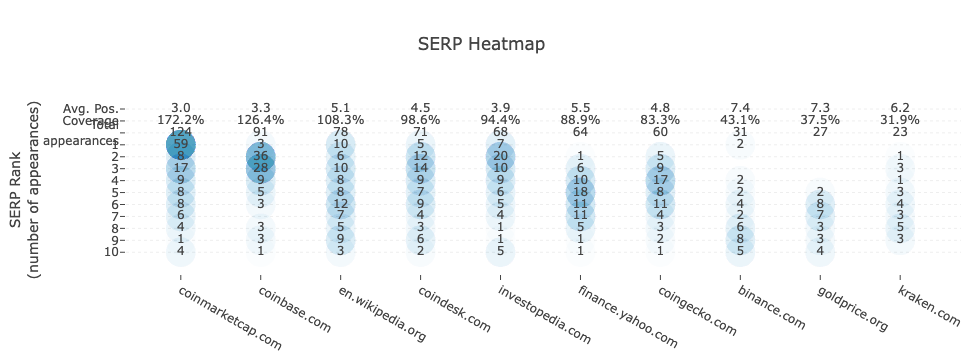

In [ ]:
serp_heatmap(serp)

## Modify some of the default options

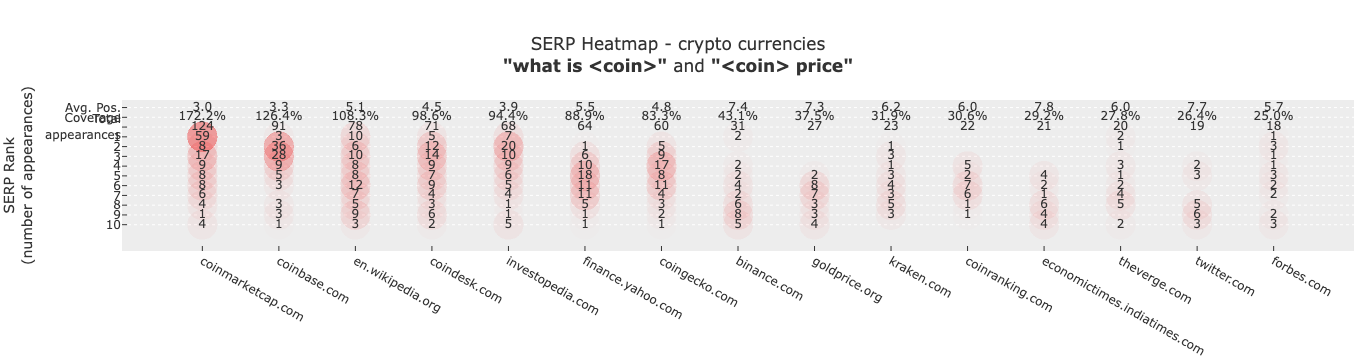

In [ ]:
serp_heatmap(
    serp,
    num_domains=15,
    title='SERP Heatmap - crypto currencies<br><b>"what is <coin>"</b> and <b>"<coin> price"</b>',
    theme="ggplot2",
)

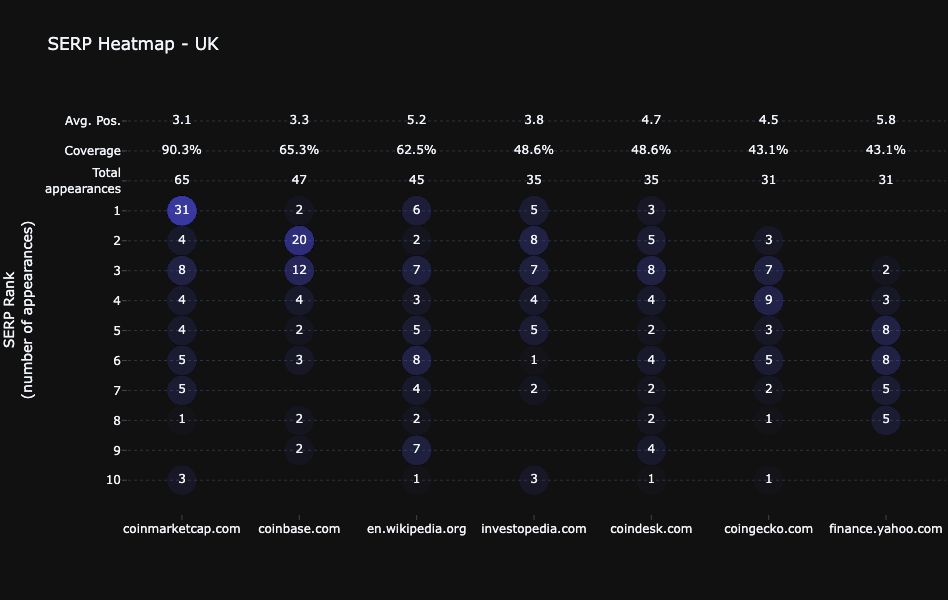

In [ ]:
serp_heatmap(
    serp[serp["gl"].eq("uk")],
    theme="plotly_dark",
    num_domains=7,
    title="SERP Heatmap - UK",
    width=800,
    height=600,
)

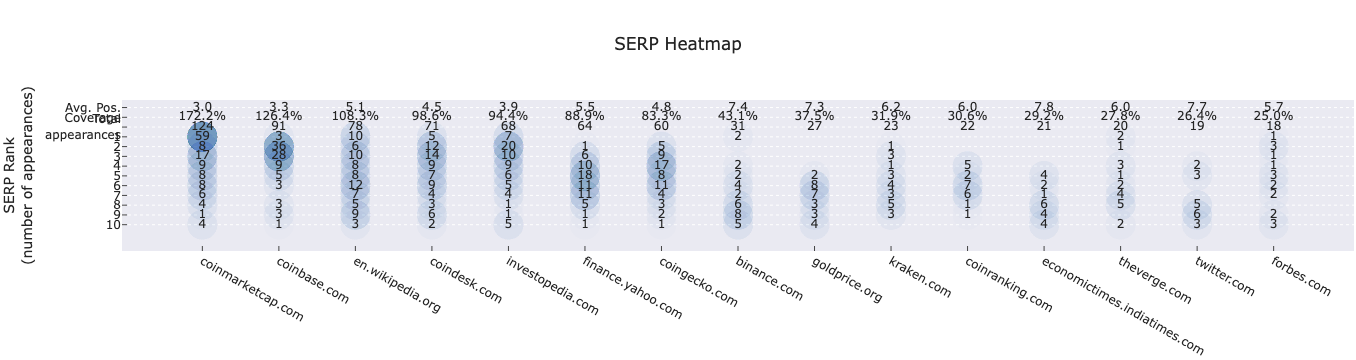

In [ ]:
serp_heatmap(serp, theme="seaborn", num_domains=15)

## Analysis - splitting the SERP DataFrame for a more meaningful subset

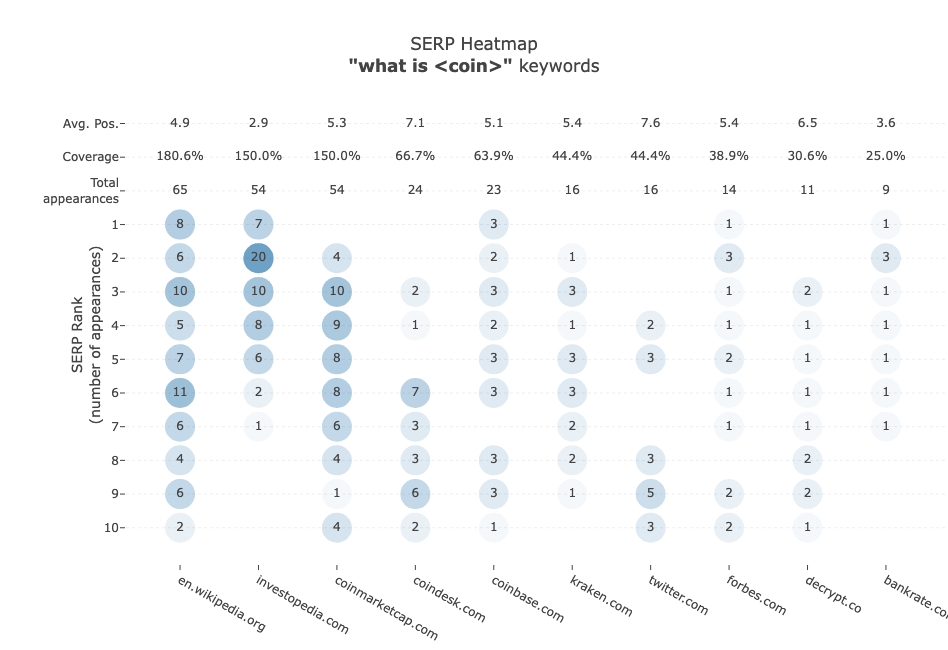

In [ ]:
what_is_df = serp[serp["searchTerms"].str.contains("what is")]
serp_heatmap(what_is_df, title='SERP Heatmap<br><b>"what is <coin>"</b> keywords')

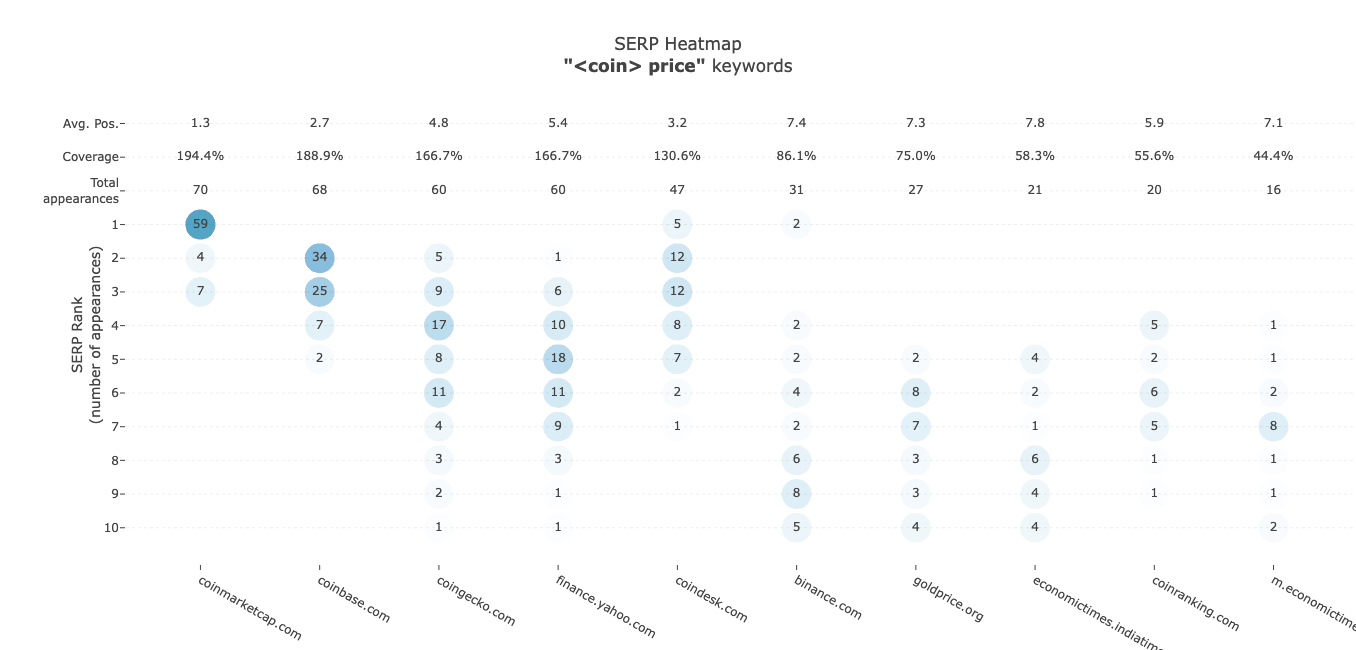

In [ ]:
price_df = serp[serp["searchTerms"].str.contains("price")]
serp_heatmap(price_df, title='SERP Heatmap<br><b>"<coin> price"</b> keywords')

It's clear how different the dominant domains are when split by keyword variant, in this case the "what is \<coin>" keywords vs. the "coin \<price>" keywords


## Add shapes and annotations for better guiding your users

* Add a rectangle to highight one or more domains
* Make the rectangle colored, or simply color the edges of the rectangle
* Optionally add a label to inform users about domain(s) in this rectangle

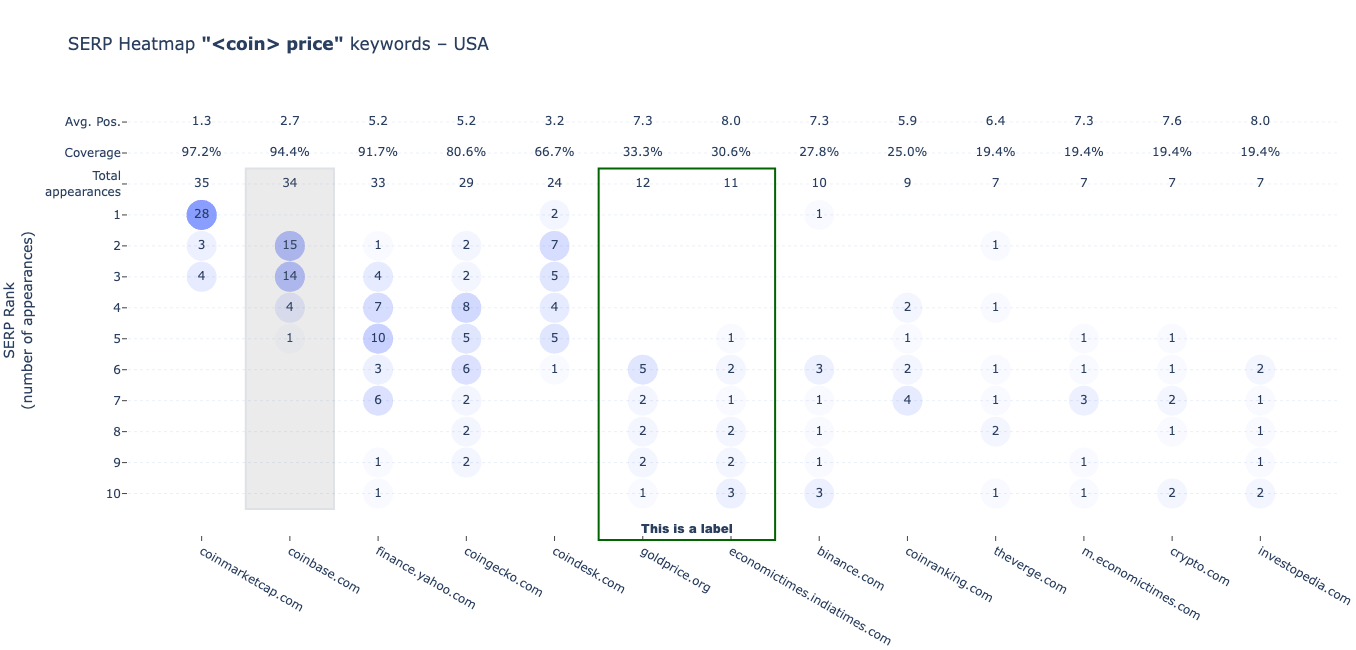

In [ ]:
fig = serp_heatmap(
    # "price" keywords in the USA:
    serp[serp["gl"].eq("us") & serp["searchTerms"].str.contains("price")],
    theme="plotly_white",
    title='SERP Heatmap <b>"<coin> price"</b> keywords – USA',
    num_domains=13,
)
fig.add_shape(
    type="rect", x0=0.5, x1=1.5, y0=-0.5, y1=10.5, fillcolor="gray", opacity=0.15
)
fig.add_shape(
    type="rect",
    x0=4.5,
    x1=6.5,
    y0=-0.5,
    y1=11.5,
    line={"color": "darkgreen"},
    label={
        "text": "This is a label",
        "font": {"family": "Arial Black"},
        "textposition": "bottom center",
    },
)
fig

## SERP Heatmap chart details

* **Avg. Pos.**: The average position of the domain shown on this column
* **Coverage**: The number of appearances of the domain on the SERP, divided by the total queries. A ratio above 100% can exist, where some domains appear more than once in the same SERP.
* **Total appearances**: the number of times the domain appeared in the SERP (from this dataset).
* Numbers in circles: Show the number of times each domain appeared in its respective position.


## Data from other sources

This chart doest not need the data from Google custom search API exclusively. There are other similar data sources like YouTube, SERP API, and SearchAPI for example. The only requirement is that you have a DataFrame with "rank", "searchTerms", and "displayLink". These columns might be named differently, in which case you only need to rename those columns. You might have "searchTerms" named as "keyword" or "query" for example, or "displayLink" named "domain". This should be straightforward.

In [ ]:
# | echo: false
serp_heatmap(serp).write_image(
    "data/images/serp_heatmap.png", width=1000, engine="kaleido", scale=2
)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()